# Часть 1. Парсинг.

По аналогии с занятием, возьмите интересующий вас сайт, на котором можно пособирать какие-то данные (и при этом API не предоставляется).


Идеальный датасет должен иметь текстовое описание некоторого объекта и некоторую целевую переменную, соответствующую этому объекту. Например:

- Сайт новостей: текстовое описание - сама новость, целевая переменная - количество просмотров новости (можно поделить на число дней с момента даты публикации, чтобы получить “среднее число просмотров в день”).
- Сайт с товарами/книгами/фильмами: текстовое описание товара/книги/фильма + средний рейтинг в качестве целевой переменной.
- Блоги - тексты заметок + число просмотров.
- И любые другие ваши идеи, которые подходят под такой формат.

Напишите свой парсер, который будет бегать по страничкам и автоматически что-то собирать.


Не забывайте, что парсинг - это ответственное мероприятие, поэтому не бомбардируйте несчастные сайты слишком частыми запросами (можно ограничить число запросов в секунду при помощи time.sleep(0.3), вставленного в теле цикла)


In [75]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from tqdm.notebook import tqdm
from fake_useragent import UserAgent
from fp.fp import FreeProxy
import numpy as np
from matplotlib import pyplot as plt


In [2]:
URL = 'https://www.livelib.ru'

In [25]:
class ProxyRequester:
    def __init__(self, requests_per_proxy = 10):
        """
        Класс для запросов на страницы через прокси.
        Меняем прокси после указанного количества запросов.
        
        :param requests_per_proxy: Количество запросов до смены прокси
        """
        requests.packages.urllib3.disable_warnings(
            requests.packages.urllib3.exceptions.InsecureRequestWarning
        )
        self.requests_per_proxy = requests_per_proxy
        self.request_count = 0
        self.current_proxy = None
        self.session = requests.Session()
        self.session.verify = False
        self._get_new_proxy()

    def _get_new_proxy(self):
        """Получить новый прокси из FreeProxy."""
        fp = FreeProxy(rand=True, timeout=1)
        self.current_proxy = fp.get()
        self.request_count = 0
        self.proxies = {
            'http': self.current_proxy,
            'https': self.current_proxy
        }

    def get(self, url):
        """
        Выполнить GET-запрос через текущий прокси.
        
        :param url: URL страницы
        :param kwargs: Дополнительные параметры для requests.get
        :return: Response или None при ошибке
        """
        
        try:
            if self.request_count >= self.requests_per_proxy:
                self._get_new_proxy()
            
            response = self.session.get(
                URL + url,
                proxies=self.proxies,
                timeout=30,
                headers={'User-Agent': UserAgent().random}
            )
            self.request_count += 1
            if response.status_code == 404:
                return None
            return BeautifulSoup(response.content, 'html.parser')
            
        except Exception as e:
            print(f"Ошибка запроса: {e}. Меняем прокси.")
            self._get_new_proxy()
            return BeautifulSoup('', 'html.parser')


In [26]:
requester = ProxyRequester(10)

In [5]:
def get_genre(url):
    '''
    Функция получает стартовый url.
    Возвращает множество, содержащее url жанров
    '''
    genre_url = set()
    soup = requester.get(url)
    genres = soup.find_all('div', attrs={'class': 'subgenre'})
    for genre in genres:
        url = genre.find('a').get('href')
        if url != 'javascript:void(0);':
            genre_url.add(url + '/best')
    print(f'Найдено {len(genre_url)} жанров')
    return genre_url
    

In [6]:
def get_text(element):
    '''
    Возвращает '' если элемент == None
    '''
    try:
        text = element.text
    except AttributeError:
        text = ''
    return text

In [32]:
def parse_book(soup):
    title = get_text(soup.find('a', attrs={'class': 'book-item__title'}))
    author = get_text(soup.find('a', attrs={'class': 'book-item__author'}))
    url = soup.find('a', attrs={'class': 'book-item__title'}).get('href')
    description = soup.find('div', attrs={'id': 'lenta-card__text-edition-full'})
    if description is None:
        book_soup = requester.get(url)
        if book_soup is not None:
            description = book_soup.find('p', attrs = {'class': 'bc-about__txt'})
            if description is None:
                description = soup.find('div', attrs={'id': 'lenta-card__text-edition-escaped'})
        else:
            description = soup.find('div', attrs={'id': 'lenta-card__text-edition-escaped'})
    description = get_text(description)
    rating = get_text(soup.find('div', attrs={'class': 'book-item__rating'}))
    return {
        'title' : title,
        'author': author,
        'description': description,
        'rating': rating,
        'url': url,
    }
    

In [27]:
def get_books(url, books):
    '''
    Функция получает список жанров.
    Возвращает множество с url книг
    '''

    for ganre in tqdm(url, desc="genre", position=0):
        for i in tqdm(range(100), desc="page", position=1, leave=True):
            page_url = ganre + f'/~{i}'
            books_soup = []
            try_count = 0
            while len(books_soup) == 0 and try_count < 3: # делаем 3 попытки получить правильную страницу. Иногда возвращает заглушку  
                soup = requester.get(page_url) 
                if soup is None:
                    books_soup = None
                    break
                books_soup = soup.find_all('li', attrs={'class': 'book-item--full'})
                try_count += 1
            if books_soup is None:
                break
            if len(books_soup) == 0:
                continue
            for book_soup in books_soup:
                book = parse_book(book_soup)
                for key, value in book.items():
                    books[key].append(value)
                books['genre'].append(ganre)
        print(f'{ganre} обработан. Собрано {len(books)} книг')
    return books

In [17]:
genre_url = get_genre('/genres')

Найдено 357 жанров


In [37]:
genre_url

{'/genre/OEL-манга/best',
 '/genre/Автомобили-и-пдд/best',
 '/genre/Альманахи/best',
 '/genre/Альтернативная-история/best',
 '/genre/Альтернативная-медицина/best',
 '/genre/Анатомия-и-физиология/best',
 '/genre/Анекдоты/best',
 '/genre/Антиутопия/best',
 '/genre/Античная-литература/best',
 '/genre/Антропология/best',
 '/genre/Археология/best',
 '/genre/Архитектура/best',
 '/genre/Астрология/best',
 '/genre/Астрономия/best',
 '/genre/Афоризмы-и-цитаты/best',
 '/genre/Базы-данных/best',
 '/genre/Банковское-дело/best',
 '/genre/Биографии-и-мемуары/best',
 '/genre/Биология/best',
 '/genre/Биохимия/best',
 '/genre/Боевая-фантастика/best',
 '/genre/Боевики/best',
 '/genre/Боевое-фэнтези/best',
 '/genre/Ботаника/best',
 '/genre/Буддизм/best',
 '/genre/Буквари/best',
 '/genre/Бухучет-налогообложение-аудит/best',
 '/genre/Вестерны/best',
 '/genre/Вирусология/best',
 '/genre/Военное-дело-спецслужбы/best',
 '/genre/Военное-дело/best',
 '/genre/Возрастная-психология/best',
 '/genre/Воспитание-дете

In [33]:
books = {
    'title' : [],
    'author': [],
    'description': [],
    'rating': [],
    'url': [],
    'genre': []
}

In [ ]:
get_books(['/genre/Юмористическая-фантастика/best'], books)

In [45]:
df = pd.DataFrame(books)


In [47]:
df.head()

,title,author,description,rating,url,genre
13,Понедельник начинается в субботу,Аркадий и Борис Стругацкие,\n Эта книга поможет вам по-нов...,"4,1",/book/1008428065-ponedelnik-nachinaetsya-v-sub...,/genre/Юмористическая-фантастика/best
14,Таня Гроттер и пенсне Ноя,Дмитрий Емец,\n Маги...,"4,2",/book/1008496933-tanya-grotter-i-pensne-noya-d...,/genre/Юмористическая-фантастика/best
15,Держи марку!,Терри Пратчетт,\n Одна...,"4,6",/book/1007051839-derzhi-marku-terri-pratchett,/genre/Юмористическая-фантастика/best
16,Космобиолухи,Андрей Уланов,\n Куда...,"4,3",/book/1001507940-kosmobioluhi-andrej-ulanov,/genre/Юмористическая-фантастика/best
17,Космоэколухи,Ольга Громыко,\n Рабо...,"4,6",/book/1000547807-kosmoekoluhi-olga-gromyko,/genre/Юмористическая-фантастика/best


### Я решил воспользоваться любезностью из ДЗ и не мучать дальше livelib

# Часть 2. NLP.

Разбейте собранные данные на train/test, отложив 20-30% наблюдений для тестирования.
Примените tf-idf преобразование для текстового описания. Используйте как отдельные токены, так и биграммы, отсейте стоп-слова, а также слова, которые встречаются слишком редко или слишком часто (параметры min/max_df), не забудьте убрать l2 регуляризацию, которая по умолчанию включена.

Если в вашем датасете целевая переменная непрерывная (например, среднее число просмотров в день), то воспользуйтесь линейной регрессией, если дискретная (положительный/отрицательный отзыв), то логистической.

Постройте регрессию с настройкой параметра регуляризации, оцените качество при помощи соответствующих задаче метрик.

Визуализируйте получившиеся коэффициенты регрессии (возьмите топ-50 слов)

Проинтерпретируйте результаты.

In [48]:
df = pd.read_csv('imdb.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [50]:
df.groupby(['sentiment']).count()

,review
sentiment,
negative,25000
positive,25000


In [56]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(
    ngram_range=(1, 2),   
    stop_words='english', 
    min_df=5,             
    max_df=0.5,
    norm=None         
)

In [54]:
X = df['review']
y = (df['sentiment'] == 'positive').astype(int)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [62]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
feature_names = tfidf.get_feature_names_out()
X_train_tfidf.shape, X_test_tfidf.shape

((37500, 117683), (12500, 117683))

In [64]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(
    random_state=42
)

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', None],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    
}

grid_clf = GridSearchCV(
    estimator=log_reg,
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc' ,     
    n_jobs=-1,
    verbose=2
)

grid_clf.fit(X_train_tfidf, y_train)

best_clf = grid_clf.best_estimator_


In [67]:
print("Лучшие параметры", grid_clf.best_params_)
print("Лучший скор на CV:", grid_clf.best_score_)


Лучшие параметры {'C': 10, 'penalty': 'l2', 'solver': 'sag'}
Лучший скор на CV: 0.9603803657455015


In [68]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred = best_clf.predict(X_test_tfidf)
y_proba = best_clf.predict_proba(X_test_tfidf)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.91      0.89      0.90      6157
           1       0.90      0.91      0.91      6343

    accuracy                           0.90     12500
   macro avg       0.90      0.90      0.90     12500
weighted avg       0.90      0.90      0.90     12500

ROC AUC: 0.9644854997782422


In [72]:
coefs = best_clf.coef_.ravel() 
idx_sorted = np.argsort(coefs)

top_neg_idx = idx_sorted[:25]      # 25 самых отрицательных
top_pos_idx = idx_sorted[-25:]     # 25 самых положительных

top_idx = np.concatenate([top_neg_idx, top_pos_idx])
top_features = feature_names[top_idx]
top_coefs = coefs[top_idx]

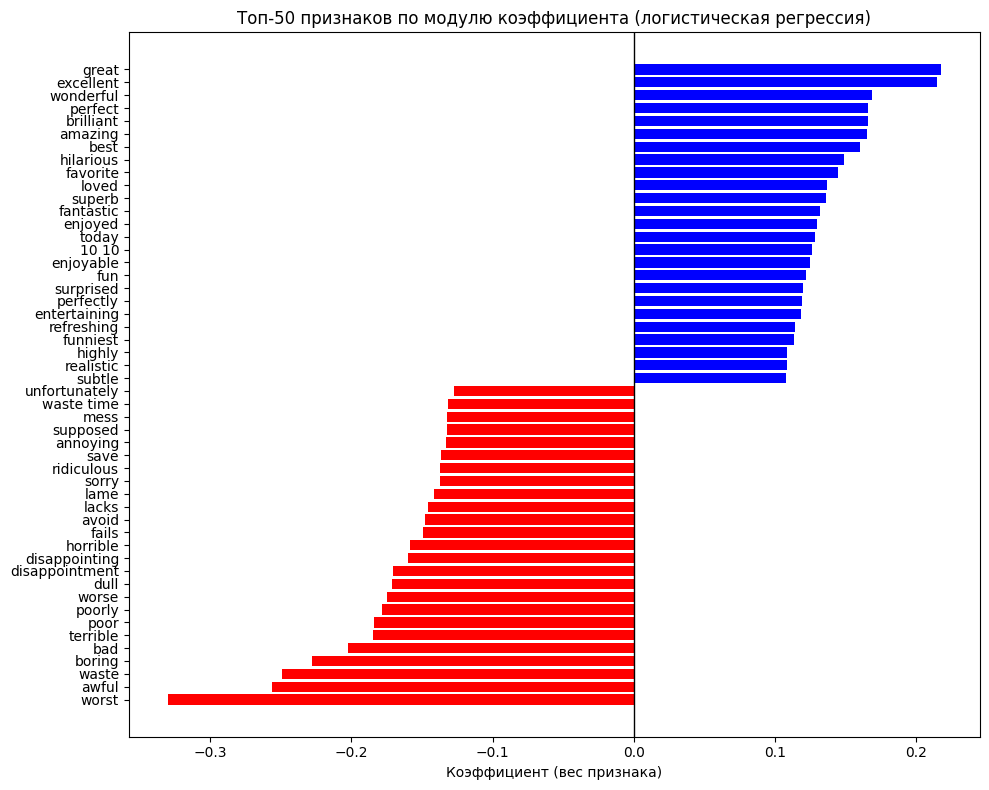

In [76]:
plt.figure(figsize=(10, 8))

# цвет: красный для отрицательных, синий для положительных
colors = ["red" if c < 0 else "blue" for c in top_coefs]
y_pos = np.arange(len(top_features))

plt.barh(y_pos, top_coefs, color=colors)
plt.yticks(y_pos, top_features)
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Коэффициент (вес признака)")
plt.title("Топ-50 признаков по модулю коэффициента (логистическая регрессия)")
plt.tight_layout()
plt.show()


### Положительные коэффициенты (синий)

Слова вроде *great, excellent, wonderful, perfect, brilliant, amazing, best, hilarious, favorite, loved* имеют крупные положительные веса. Это означает, что их наличие в отзыве **сильно увеличивает** вероятность положительного класса. Чем больше коэффициент, тем сильнее вклад слова в «положительность» текста при прочих равных.

### Отрицательные коэффициенты (красный)

Слова *worst, awful, waste, boring, bad, terrible, poor, worse, dull, disappointing, disappointment, horrible* имеют крупные отрицательные веса. Их появление **увеличивает** вероятность отрицательного класса. Особенно сильные по модулю коэффициенты у *worst, awful, waste, boring* — такие слова почти однозначно ассоциируются с негативом.